# Qiskit Tutorial 4 - Training a SMILES Dataset with Support Vector Regression

1. S. G. Nana Engo, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
1. J-P. Tchapet Njafa, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
1. M. V. SAO TEMGOUA, myke-vital.sao@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaoundé 1

April 2023

<center>
  <img src='./Graphics/ML.jpg' width=650 />
</center>

In this notebook, we will cover how to implement a machine learning model for **the prediction of the solubility of drug compounds**.

We will load, prepare, featurize, and scale/normalize the input datasets in the same way as we did in the previous notebook (Qiskit Tutorial 3).

The purpose here is to use the `Support Vector Regressor` [SVR model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR), to predict the **partition coefficient** `logP`, which is, in an experimental measurements, the ratio of concentrations of a compound in a mixture of two immiscible solvents at equilibrium. Our dataset is composed of  [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), that is, **Simplified Molecule-Input Line-Entry System**. It describes the chemical species by short strings. <br>

Our goal is to
<div class="alert alert-info">
     <strong> 
- become accustomed to using RDKit, an Open source toolkit for cheminformatics; <br> 
- perform a simple regression task - prediction of logP values using molecular fingerprint.
    <strong> 
</div>
</br>

It should be noted that, we are already familiar with **Support vector machines (SVMs)** that are a set of supervised learning methods used for classification (SVC, Qiskit Tutorial 3) and regression.

## Reading and writing molecules

This is a short overview for creating molecules from and writing molecules into various file formats. It is intended to be a complement to, not replacement for, the contents of the [main RDKit documentation](http://rdkit.org/docs/index.html). 

Let's look further about Asprin using RDKit.

In [3]:
# Uncomment the line below to install rdkit
# !pip install rdkit -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 93.2 kB/s eta 0:00:0000:0100:08
  Attempting uninstall: rdkit
    Found existing installation: rdkit 2023.3.1
    Uninstalling rdkit-2023.3.1:
      Successfully uninstalled rdkit-2023.3.1


In [15]:
from rdkit import Chem

smi = 'O=C(C)Oc1ccccc1C(=O)O'
m = Chem.MolFromSmiles(smi) # Convert smiles to molecule
m

ModuleNotFoundError: No module named 'rdkit_ipynb_tools'

In [2]:
print(f'The number of heavy atoms (non-hydrogen atoms) in the molecule is {m.GetNumHeavyAtoms()}')

The number of heavy atoms (non-hydrogen atoms) in the molecule is 13


* We can represent hydrogen atoms explicitly by using the keyword `AllChem.AddHs`.

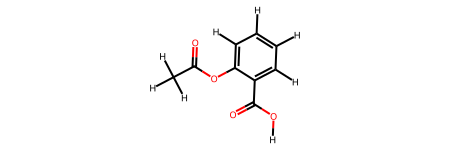

In [3]:
from rdkit.Chem import AllChem

m1 = AllChem.AddHs(m)
m1

* We can find adjacency and atomic features information. <br>
Thanks to the already implemented functions in rdkit, we can obtain that information by just typing relevant keywords. <br>
We will use the graph structure as inputs for graph neural networks (GNNs) later.

In [4]:
adj = Chem.rdmolops.GetAdjacencyMatrix(m)
adj ## Adjacency matrix : a(i,j) == 1 if atom pair (i,j) is connected and 0 lse.

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [5]:
for atom in m.GetAtoms():
    print (atom.GetIdx(), "th atom is ", atom.GetSymbol(), ", total number of hydrogens is", atom.GetTotalNumHs(), 
           ", and aromaticity indicator is", atom.GetIsAromatic())

0 th atom is  O , total number of hydrogens is 0 , and aromaticity indicator is False
1 th atom is  C , total number of hydrogens is 0 , and aromaticity indicator is False
2 th atom is  C , total number of hydrogens is 3 , and aromaticity indicator is False
3 th atom is  O , total number of hydrogens is 0 , and aromaticity indicator is False
4 th atom is  C , total number of hydrogens is 0 , and aromaticity indicator is True
5 th atom is  C , total number of hydrogens is 1 , and aromaticity indicator is True
6 th atom is  C , total number of hydrogens is 1 , and aromaticity indicator is True
7 th atom is  C , total number of hydrogens is 1 , and aromaticity indicator is True
8 th atom is  C , total number of hydrogens is 1 , and aromaticity indicator is True
9 th atom is  C , total number of hydrogens is 0 , and aromaticity indicator is True
10 th atom is  C , total number of hydrogens is 0 , and aromaticity indicator is False
11 th atom is  O , total number of hydrogens is 0 , and aro

More atomic features can be obtained by using `rdkit.Chem.AtomPair` with keywords listed at [this link] (http://rdkit.org/docs/source/rdkit.Chem.AtomPairs.html).

* We can obtain several molecular properties, such as molecular weight, logP - partition coefficient, TPSA - polarity, QED (quantitative estimation of druglikeness), etc. See [List of Available Descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors) online.

In [6]:

molwt = Chem.Descriptors.ExactMolWt(m)
logP = Chem.Descriptors.MolLogP(m)
tpsa = Chem.Descriptors.TPSA(m)
hamolwt = Chem.Descriptors.HeavyAtomMolWt(m)
Qed = Chem.QED.qed(m)

print(f'Our molecular properties are :\n Molecular weight={molwt}, \n Polarity={tpsa}, \n Solubility={logP}, \n Average molecular weight={hamolwt}, \n Quantitative drug-likeness={Qed}')

Our molecular properties are :
 Molecular weight=180.042258736, 
 Polarity=63.60000000000001, 
 Solubility=1.3101, 
 Average molecular weight=172.09499999999997, 
 Quantitative drug-likeness=0.5501217966938848


We will obtain molecular fingerprint (extended connectivity fingerprint - ECFP). <br>
The **molecular fingerprint** represents the substructures of a molecule as a vector of binary numbers. It is a molecular structure descriptor, and we can use it as input to reveal the relationship between molecular structure and properties, called **Quantitative Structure-Activity Relationships (QSAR)**.

<center>
  <img src='./Graphics/morgan_fp1.png' width=340/>
</center>

* We need feature vectors (matrix) as inputs for neural networks. 

In [7]:
from rdkit import DataStructs
import numpy as np

fps = []
fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) 
# the number 2 denotes the number of iterations in Morgan algorithm.

fp_arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, fp_arr)
fps.append(fp)

fps = np.asarray(fps) # Convert our encoded molecule to an array
fps.shape

(1, 1024)

As we see, by using modules, we do not need to implement functions to get atomic and molecular features manually.

In the following, we will use the **regression model** to predict partition coefficient (logP) of molecules using the molecular fingerprint.

## Exploratory Data Analysis

* The path access of our prepared ZING dataset that is part of [ZINC database](http://zinc.docking.org/).

In [8]:
import os
import pandas as pd

PATH = os.getcwd()
data_path = os.path.join(PATH, './Dataset/zinc15.txt')

* Open of our dataset inside a `Pandas Data Frame`

In [9]:
with open(data_path, 'r') as f:
    content = f.readlines()
    smile = [smi.split()[0] for smi in content]
    
smile

['Cc1cc(C(=O)NCCN2CCCC2=O)c(C)n1-c1ccc(C#N)cc1',
 'N#Cc1cc(C#N)c(NCCc2cnc(N)s2)nc1Cl',
 'C=C[C@](C)(CC)C(=O)N[C@@H]1CN(CCCC2CCC2)C[C@@H]1O',
 'CC#CCN[C@@H]1CCCN(C(=O)[C@H](C)OCCOCC)C1',
 'C[C@H](NC(=O)C(=O)NCCCCC#N)c1cccc(C(F)(F)F)c1',
 'C=CCn1c(C[C@@H](C)SC)nnc1N(C)C[C@](C)(O)c1ccccc1',
 'C=CCN1CC[C@@H]2[C@H](CCCN2C(=O)Cc2c(C)n[nH]c2C)C1',
 'C=CCOCc1nn(CC2CC2)c2c1CN(C[C@H](C)C(=O)OC)CC2',
 'C[C@H](CCc1ccccc1)Nc1ccc(C#N)cc1F',
 'C=C1CCC(C(=O)N[C@H](C)C[C@@H](C)NCC(N)=O)CC1',
 'C=C(C)CN(C)Cn1nc(N2CCCC2)n(-c2ccccc2Cl)c1=S',
 'Cc1nc(C(=O)N2CCCC[C@@H]2c2cc(NC(=O)c3cccc([C@H](C)C#N)c3)n[nH]2)c(=O)[nH]c1C',
 'C=CCOc1cccc(NC(=O)C(=O)Nc2cnn(C)c2)c1',
 'CC[C@H](C)NC(=O)c1ccc(NC(=O)CCc2ccc(C#N)cc2)c(C)c1',
 'C#CCCCC(=O)N[C@@]1(C)CCCc2ccccc21',
 'C=CCOCCN(C)[C@H]1CCN(CC)[C@H](C)C1',
 'CCc1ccccc1NC(=O)CN(C)C(=O)CSCc1ccc(C#N)cc1',
 'Cc1nn(-c2ccccn2)c(C)c1/C=C/C(=O)c1ccc(C(=O)O)cc1O',
 'N#Cc1cc(Nc2ccsc2)cc(F)c1F',
 'COc1cccc([C@@H]2C[C@@H](C)CN2c2nnc(-c3ccc(C#N)cc3)n2C[C@H]2CCOC2)c1',
 'C[C@@H]1CN(c

In [10]:
df = pd.DataFrame(data=smile, columns=['Smiles'])
df

,Smiles
0,Cc1cc(C(=O)NCCN2CCCC2=O)c(C)n1-c1ccc(C#N)cc1
1,N#Cc1cc(C#N)c(NCCc2cnc(N)s2)nc1Cl
2,C=C[C@](C)(CC)C(=O)N[C@@H]1CN(CCCC2CCC2)C[C@@H]1O
3,CC#CCN[C@@H]1CCCN(C(=O)[C@H](C)OCCOCC)C1
4,C[C@H](NC(=O)C(=O)NCCCCC#N)c1cccc(C(F)(F)F)c1
...,...
9995,N#Cc1cccc(NC(=O)NCCN2C(=O)CCC2=O)n1
9996,C=C[C@@H]1OCC[C@H]1C(=O)N1C[C@H]2CCN(Cc3nnc(CC...
9997,CC[C@@H](NC(=O)Nc1ccc(C#N)c(C(F)(F)F)c1)[C@@H]...
9998,C=CCn1c([C@H]2CCS(=O)(=O)C2)nnc1N1CCN(C(=O)N2C...


* The table/frame contains SMILES that can be converted to `RDKit` molecules.

,Smiles,Molecules
0,Cc1cc(C(=O)NCCN2CCCC2=O)c(C)n1-c1ccc(C#N)cc1,
1,N#Cc1cc(C#N)c(NCCc2cnc(N)s2)nc1Cl,
2,C=C[C@](C)(CC)C(=O)N[C@@H]1CN(CCCC2CCC2)C[C@@H]1O,
3,CC#CCN[C@@H]1CCCN(C(=O)[C@H](C)OCCOCC)C1,
4,C[C@H](NC(=O)C(=O)NCCCCC#N)c1cccc(C(F)(F)F)c1,
...,...,...
9995,N#Cc1cccc(NC(=O)NCCN2C(=O)CCC2=O)n1,
9996,C=C[C@@H]1OCC[C@H]1C(=O)N1C[C@H]2CCN(Cc3nnc(CC...,
9997,CC[C@@H](NC(=O)Nc1ccc(C#N)c(C(F)(F)F)c1)[C@@H]...,
9998,C=CCn1c([C@H]2CCS(=O)(=O)C2)nnc1N1CCN(C(=O)N2C...,

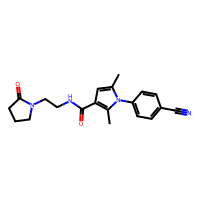
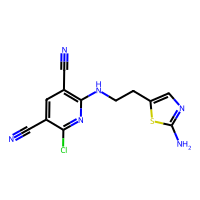
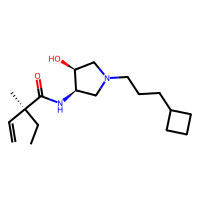
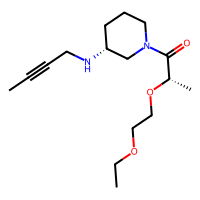
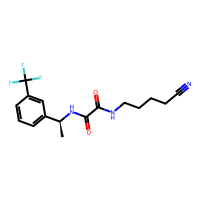
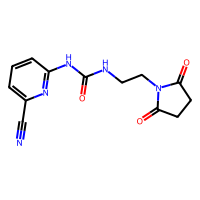
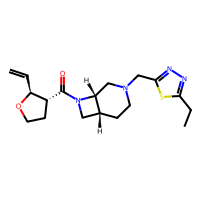
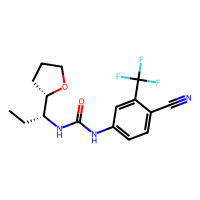
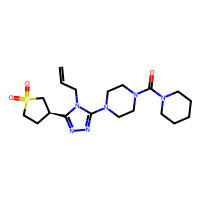
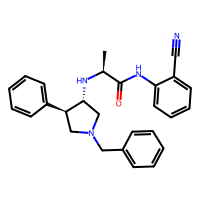

In [11]:
Chem.PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='Smiles', molCol='Molecules')
df

* We check if there is rows where RDKit failed to generate molecules from SMILES.

In [12]:
df.isnull().sum()

Smiles       0
Molecules    0
dtype: int64

* We evaluate some descriptors, the physicochemical properties of our compounds.

In [13]:
def calculate_descriptors(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    psa = Descriptors.TPSA(mol)
    rb = Descriptors.NumRotatableBonds(mol)
    rg = Descriptors.NumAromaticRings(mol)
    qed = Chem.QED.qed(mol)
    return [mw, logp, hbd, hba, psa, rg, rb, qed]

In [14]:
molecule = df.iloc[:, 1].values
descriptors = [calculate_descriptors(mol) for mol in molecule]

NameError: name 'Chem' is not defined

In [ ]:
descriptors_df = pd.DataFrame(descriptors, columns=['MW', 'LogP', 'HBD', 'HBA', 'PSA', 'Aromatic Rings', 'Rotatable Bonds', 'QED'])
data = pd.concat([df, descriptors_df], axis=1)
data

* We check again if there are empty values in our new dataset.

In [ ]:
data.isnull().sum()

* Let's evaluate the fingerprint of each molecules in our dataset.

In [ ]:
fps = []
for mol in molecule:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    fp_arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, fp_arr)
    fps.append(fp)

In [ ]:
# Convert the fingerprint as an array 
fps = np.asarray(fps)
fps

In [ ]:
fps.shape

## Splitting our dataset 

As usual, before starting train our model, we will split our dataset in train/test dataset. It should be noted that,

1. **inputs**: fingerprint (features) of each molecules
2. **outputs**: partition coefficient `logP`. 

In [ ]:
logp = data.iloc[:,3].values

* We first check that our inputs/outputs have the same number of lines.

In [ ]:
logp.shape[0] == fps.shape[0]

In [ ]:
from sklearn.model_selection import train_test_split

seed = np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(fps, logp, train_size=0.8, random_state=seed)

## Train our model with `Support Vector Regressor-SVR`

* Let's now train our Support Vector Regressor [SVR model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) from scikit-learn.

In [ ]:
from sklearn.svm import SVR

svr = SVR()
_ = svr.fit(X_train, y_train)

* After the training, we use `sklearn.metrics.r2_score` and `sklearn.metrics.mean_squared_error` to check the accuracy of our prediction.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

logp_predict = svr.predict(X_test)
r2 = r2_score(y_test, logp_predict)
mse = mean_squared_error(y_test, logp_predict)

print(f'The r2_score is {r2}  and the mean square error is {mse}')

* Visualization of the results from the model. We will plot (True values - Predicted values), and draw the linear regression between them by using `scipy.stats.linregress`.

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

vect_norm, intercept, r_value, p_value, std_error = stats.linregress(y_test, logp_predict)
fx = vect_norm * y_test + intercept

plt.scatter(y_test, logp_predict, color='green', s=2)
plt.plot(y_test, fx, label='Predicted logP ='+str(round(vect_norm,2))+'*True logP +'+str(round(intercept,2)), linewidth=2)
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.legend()
plt.show()

*In summary, **we use a SVR model for prediction of logP**. With prepared dataset, we can easily preprocess, construct the model and validated the results.*

## Do it yourself

Use a support vector regression (SVR) to predict logP (partition coefficeint) from molecules of the ZING Dataset contained in the file `'./Dataset/smilesZn100.txt`. The input - structural feature of molecules is Morgan fingerprint and the eoutput is logP.

The workflow is
1. Get molecular fingerprints of each molecules 
2. Split the dataset to training set and test set
3. Train a SVR model
4. Validate the trained model using test-set


## Short summary on Support Vector Machine

A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. The main idea behind many classification algorithm is to represent data in $\mathbb{R}^D$ and then partition this space; ideally in way that examples with the same label (and no other examples) are in the same partition. Let $x \in \mathbb{R}^D$ be an element of the data space. Consider a function 
\begin{equation}
  \begin{array}{lrcl}
    f : & \mathbb{R}^{D} & \longrightarrow & \mathbb{R}        \\
        & x                 & \longmapsto     & f(x)=\langle w, x\rangle + b,
  \end{array}
\end{equation}
where $\langle w, x\rangle$ is the scalar product between the two vectors.

### Separating hyperplanes
We use the hyperplane to divide the space into two parts. Let example $x \in \mathbb{R}^D$ be an element of the data space. Therefore, we define the hyperplane that seperates the two classes in our binary classification problem as 
\begin{equation}
\{x \in \mathbb{R}^D : f(x)=\langle w, x\rangle + b=0\}
\end{equation}
$w$ is the `normal vector` to the hypeplane and $b$ the `intercept`.

When training the classifier, we want to ensure that the examples with positive labels are on the positive side of the hyperplane and the negative labels on the other side, i.e
\begin{equation}
    y_n(\langle w, x\rangle + b)\geq 0, ~\text{for}~y_n\in\{-1, 1\}  
\end{equation}

<center>
 <img src='./Graphics/margin.png' width=500 /> 
</center>